# Анализ поведения пользователей мобильного приложения

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Изучение-и-проверка-данных" data-toc-modified-id="Изучение-и-проверка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Изучение и проверка данных</a></span></li><li><span><a href="#Воронка-событий" data-toc-modified-id="Воронка-событий-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Воронка событий</a></span></li><li><span><a href="#Изучим-результаты-эксперемента" data-toc-modified-id="Изучим-результаты-эксперемента-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Изучим результаты эксперемента</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Подготовка данных

Для начала сохраним нашу таблицу в переменной и изучим ее. Путь к файлу: `/datasets/logs_exp.csv`

In [1]:
# Подгрузим необходимые нам библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import plotly.express as px
import math as mth
from scipy import stats as st

In [2]:
try:
    aab_data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    print('Не удалось загрузить файл')

In [3]:
aab_data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
#Заменим название столбцов
aab_data.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

In [5]:
# Проверм данные на наличие дубликатов
aab_data.duplicated().sum()

413

Ввиду того, что дубликаты составляют менее 1% от датафрейма, то мы их просто удалим

In [6]:
print(f'Строк в aab_data перед началом обработки: {aab_data.shape[0]}')

Строк в aab_data перед началом обработки: 244126


In [7]:
aab_data = aab_data.drop_duplicates()
aab_data.shape[0]

243713

In [8]:
# Проверим на наличие пропусков
aab_data.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

In [9]:
# Изучим содержание столбцов event_name и exp_id
display(aab_data['event_name'].unique())
aab_data['exp_id'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

array([246, 248, 247])

In [10]:
# Изучим типы данных
aab_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       243713 non-null  object
 1   device_id_hash   243713 non-null  int64 
 2   event_timestamp  243713 non-null  int64 
 3   exp_id           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


In [11]:
# Добавим столбец даты и времени, а также отдельный столбец дат
aab_data['event_datetime'] = pd.to_datetime(aab_data['event_timestamp'], unit='s')
aab_data['event_date'] = aab_data['event_datetime'].astype('datetime64[D]')
aab_data.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Проверим нет ли у нас пользователей, которые оказались сразу в нескольких группах

In [12]:
check = aab_data.groupby('device_id_hash')['exp_id'].nunique().reset_index().sort_values('exp_id', ascending=False)
check.head()

,device_id_hash,exp_id
0,6888746892508752,1
5030,6207768971558512760,1
5042,6217807653094995999,1
5041,6217295124800833842,1
5040,6216080220799726690,1


Исходя из полученной таблицы, видно что пользователи не пересекаются.

На данном этапе мы подгрузили и подготовили наши данные к дальнейшей работе. Также дополнительно создали 2 столбца с датой и временем, а также только с датой. Проверили пользователей на пересечение.

## Изучение и проверка данных

После подготовки датафрейма к работе, изучим и проверим данные. Ответим на следующие вопросы:
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период мы располагаем? Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. Можем ли мы быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые. Данными за какой период времени мы располагаете на самом деле?
- Много ли событий и пользователей мы потеряли, отбросив старые данные?
- Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

Так как каждая запись в логе — это действие пользователя, или событие, то количество строк в нашем датафрейме - это всего событий в логе.

In [13]:
display(f'Всего событий в логе - {aab_data.shape[0]}')
display(f'Всего пользователей в логе - {aab_data["device_id_hash"].nunique()}')

'Всего событий в логе - 243713'

'Всего пользователей в логе - 7551'

Найдем среднее количество заказов на пользователя. Для начала изучим наши данные на аномалии.

,device_id_hash,event_name
count,7.551000e+03,7551.000000
mean,4.677319e+18,32.275593
std,2.655343e+18,65.154219
min,6.888747e+15,1.000000
25%,2.397700e+18,9.000000
50%,4.688022e+18,20.000000
75%,7.007353e+18,37.000000
max,9.222603e+18,2307.000000


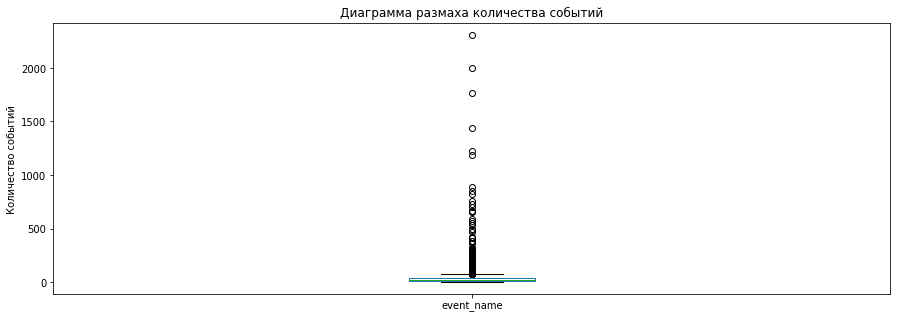

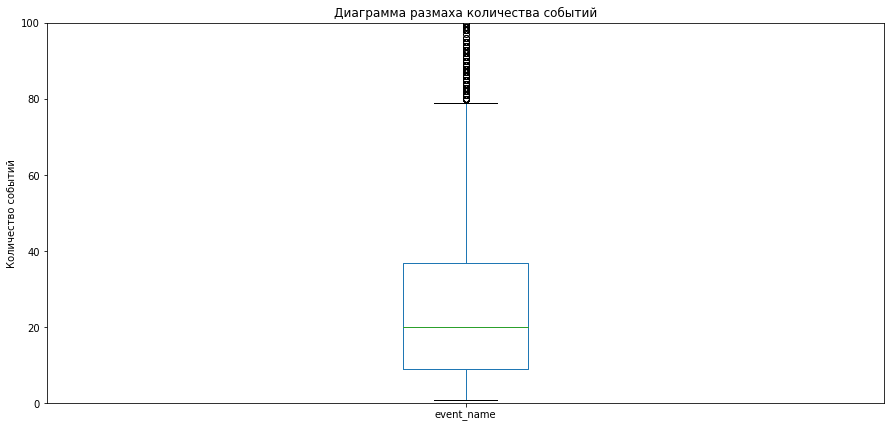

array([ 89. , 200.5])

In [14]:
# Создадим датафрейм с количеством события на уника
data_boxplot = aab_data.groupby('device_id_hash').agg({'event_name':'count'}).reset_index()

# Посмотри на данные с помощью метода describe
display(data_boxplot.describe())

# Построим диаграмму размаха
data_boxplot.plot(kind='box', figsize=(15, 5), y='event_name')
plt.title('Диаграмма размаха количества событий')
plt.xlabel(' ')
plt.ylabel('Количество событий')
plt.show()

# Приблизим диаграмму размаха
data_boxplot.plot(kind='box', figsize=(15, 7), y='event_name')
plt.ylim(0, 100)
plt.title('Диаграмма размаха количества событий')
plt.xlabel(' ')
plt.ylabel('Количество событий')
plt.show()

np.percentile(data_boxplot["event_name"], [95, 99])

Исходя из полученных результатов видно, что в данных содержатся аномалии. Находятся пользователи, у которых количество событий превышает 2000. Не более 95% пользователей совершили лишь 89 событий. Посмотрим, какой процент данных мы потеряем при удалении данных пользователей из нашего датафрейма

In [15]:
anomal_users = list(data_boxplot.query('event_name > 89')['device_id_hash'])
print(
    f'Сейчас в данных содержится {aab_data.shape[0]} событий.'
)
print(
    f'После удаление аномальных пользователей из датафрейма, останется {aab_data.query("device_id_hash not in @anomal_users").shape[0]}'
)
print(
    f'Что составляет {round((aab_data.shape[0] - aab_data.query("device_id_hash not in @anomal_users").shape[0])/aab_data.shape[0]*100,2)}% от исходных данных'
)

Сейчас в данных содержится 243713 событий.
После удаление аномальных пользователей из датафрейма, останется 172741
Что составляет 29.12% от исходных данных


Ввиду того, что аномалии составляют 29% от исходного датафрейма, то их удаление повлечет за собой искажение данных. На данном этапе оставим этих пользователей. Для определения среднего количества заказов на пользователя, воспользуемся медианным значением. В среднем на пользователя приходится 20 событий.

Посмотрим данными за какой период мы располагаем. Найдем максимальную и минимальную даты, а также построим гистограмму по дате и времени.

In [16]:
f' В нашем распоряжении данные за преиод с {aab_data["event_datetime"].min()} по {aab_data["event_datetime"].max()}'

' В нашем распоряжении данные за преиод с 2019-07-25 04:43:36 по 2019-08-07 21:15:17'

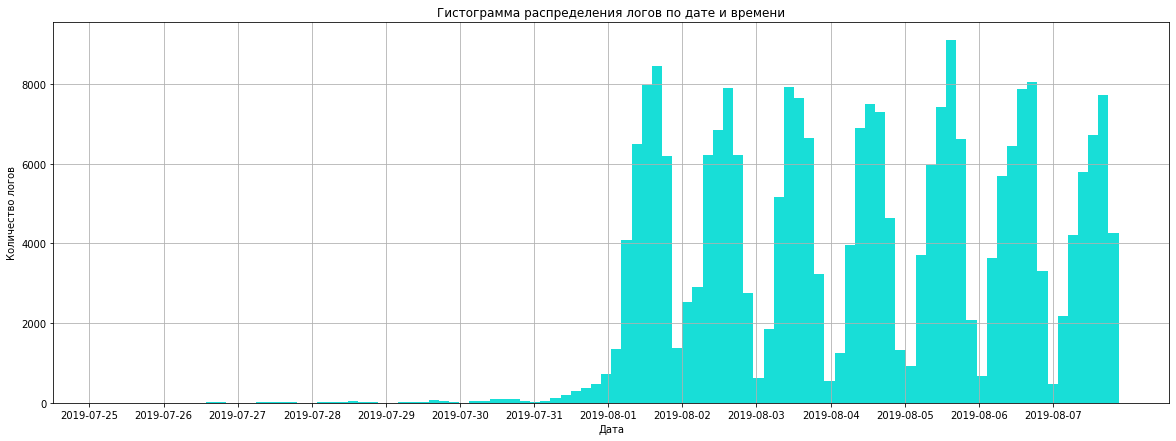

In [17]:
plt.figure(figsize=(20,7))
plt.hist(aab_data['event_datetime'], bins=100, color='#18ded7')
plt.title('Гистограмма распределения логов по дате и времени')
plt.ylabel('Количество логов')
plt.xlabel('Дата')
plt.xticks(aab_data['event_date'].unique())
plt.grid()
plt.show()

Благодаря полученной гистограмме можно заметить, что корректно логи начали "подтягиваться" начиная с 1 августа. До этого момента данные не полные, и использовать их в дальнейшем некорректно. Для этого создадим новый датафрейм, в котором сохраним логи начиная с 1 августа, включительно.

In [18]:
aab_data_act = aab_data.query('event_date >= "2019-08-01"')

После "чистки" датафрейма, теперь мы располагаем данными за недельный период - с 1 по 7 августа, включительно.

Проверим, много ли пользователей и событий мы потеряли, отбросив старые данные.

In [19]:
# Узнаем количество 'потеряных' логов, а также их процент
print(aab_data.shape[0] - aab_data_act.shape[0])
print((aab_data.shape[0] - aab_data_act.shape[0])/aab_data.shape[0]*100)

2826
1.159560630741897


In [20]:
# Узнаем количество 'потеряных' пользователей
print(aab_data['device_id_hash'].nunique() - aab_data_act['device_id_hash'].nunique())
print((aab_data['device_id_hash'].nunique() - aab_data_act['device_id_hash'].nunique())/aab_data['device_id_hash'].nunique()*100)

17
0.22513574361011784


После чистки данных мы избавились всего от 2826 логов и 17 уникальных пользователей, что составляет 1.15% и 0.22% соответственно. Теперь проверим какое количество пользователей приходится на каждую из групп.

In [21]:
aab_data_act.pivot_table(index='exp_id', values='device_id_hash', aggfunc='nunique')

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


По группам видно небольшое расхождение в пользователях. На эксперементальную 248 группу приходится 2537 пользовталей, что менее чем на 1% больше, чем в 247 группе, и на 2% больше, чем в 246 группе.

В данном разделе мы изучили наши данные, определили сколько событий и пользователей в логе, а также изучили данные на аномалии. Изучили период котороым мы располагаем, отбросив период с неполным данными.

## Воронка событий

Изучим воронку события для нашего стратапа.

Для начала посмотрим, какие события есть в логах и как часто они встречаются.

In [22]:
aab_data_act['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Теперь посчитаем, сколько пользователей совершали каждое из этих событий.

In [23]:
events_cnt = (
    pd.DataFrame(aab_data_act.groupby('event_name')['device_id_hash']
                 .nunique().sort_values(ascending=False)).reset_index()
)
events_cnt

,event_name,device_id_hash
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Посчитаем долю пользователей, которые хоть раз совершали событие.

In [24]:
(
    pd.DataFrame(aab_data_act.groupby('event_name')['device_id_hash'].nunique()
                 /aab_data_act['device_id_hash'].nunique()*100)
    .sort_values('device_id_hash', ascending=False).style.format('{:.1f}%')
)

,device_id_hash
event_name,
MainScreenAppear,98.5%
OffersScreenAppear,61.0%
CartScreenAppear,49.6%
PaymentScreenSuccessful,47.0%
Tutorial,11.1%


Исходя из полученной таблицы, события имеют следующий порядок `MainScreenAppear` (главный экран) -> `OffersScreenAppear` (экран предожения) -> `CartScreenAppear` (корзина) -> `PaymentScreenSuccessful` (экран успешной оплаты). Событие `Tutorial` (обучение) редко используется пользователями и никак не задействована в воронке событий. Главное событие `MainScreenAppear` - было показано только в 98.5% случаев, что может свидетельствовать о возможных багах приложения.

Для наглядности изобразим воронку с абсолютными значениями.

In [42]:
u_funnel = events_cnt.query('event_name != "Tutorial"')
fl = px.funnel(u_funnel, x='device_id_hash', y='event_name', title='Воронка событий')

fl.show()

Посмотрим какая доля пользователей доходит от первого события до оплаты. Так как событие Tutorial никак не относится к воронке событий, то уберем ее.

In [26]:
# Создадим для этого новую переменную, и в дальнейшем будем работат с ней
clear_data = aab_data_act.query('event_name != "Tutorial"')

In [27]:
# Для пользователей найдем время первого срабатывания каждого события
events_users = clear_data.pivot_table(
    index='device_id_hash', 
    columns='event_name', 
    values='event_datetime',
    aggfunc='min')
events_users.head()

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
device_id_hash,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45


In [28]:
# Найдем количество пользователей на каждом шаге
step_1 = ~events_users['MainScreenAppear'].isna()
step_2 = step_1 & (events_users['OffersScreenAppear'] > events_users['MainScreenAppear']) 
step_3 = step_2 & (events_users['CartScreenAppear'] > events_users['OffersScreenAppear']) 
step_4 = step_3 & (events_users['PaymentScreenSuccessful'] > events_users['CartScreenAppear']) 

In [29]:
temp = (
    {'funnel_stage':list(clear_data['event_name'].unique())
     , 'users_cnt': [step_1.sum(), step_2.sum(), step_3.sum(), step_4.sum()]}
)
events_funnel = pd.DataFrame(data=temp)
events_funnel['CR'] = round(events_funnel['users_cnt']/step_1.sum()*100, 2)
display(events_funnel)
f2 = px.funnel(events_funnel, y='funnel_stage', x='users_cnt', title='Воронка событий пользователей прошедших все этапы')
f2.show()

,funnel_stage,users_cnt,CR
0,MainScreenAppear,7419,100.00
1,OffersScreenAppear,4201,56.62
2,CartScreenAppear,1767,23.82
3,PaymentScreenSuccessful,454,6.12


Чуть более 6% пользователей проходят весь путь воронки до этапа оплаты.

На даном этапе мы изучили воронку, по которой проходят пользователи. А также нашли процент пользователей, которые проходят весь путь воронки от начал до конца.

## Изучим результаты эксперемента

Для начала посмотрим сколько пользователей в каждой из групп

In [30]:
users_in_group = clear_data.pivot_table(index='exp_id', values='device_id_hash', aggfunc='nunique').reset_index()
users_in_group.columns = ['exp_id', 'users_cnt']
users_in_group

,exp_id,users_cnt
0,246,2483
1,247,2512
2,248,2535


In [31]:
# разделим данные по каждой группе и обозначим долю пользователей совершивших каждое событие, для удобства сделаем функцию
def sep_group(id):
    temp = clear_data.query('exp_id == @id')
    temp2 = temp.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False).reset_index()
    temp3 = temp['device_id_hash'].nunique()
    temp2.loc[len(temp2)]=['TotalUsers', temp3]
    temp2.columns = ['event_name', 'users_cnt']
    temp2['sou'] = round(temp2['users_cnt']/temp3*100, 2)
    return  temp2.sort_values('users_cnt', ascending=False).reset_index(drop=True)

In [32]:
# Сохраним все в соответствующие переменные
a1_246 = sep_group(246)
a2_247 = sep_group(247)
b_248 = sep_group(248)
aa_246_247 = sep_group([246, 247])

Проверим корректность работы формулы:

In [33]:
display(a1_246)
display(a2_247)
display(b_248)
display(aa_246_247)

,event_name,users_cnt,sou
0,TotalUsers,2483,100.00
1,MainScreenAppear,2450,98.67
2,OffersScreenAppear,1542,62.10
3,CartScreenAppear,1266,50.99
4,PaymentScreenSuccessful,1200,48.33


,event_name,users_cnt,sou
0,TotalUsers,2512,100.00
1,MainScreenAppear,2476,98.57
2,OffersScreenAppear,1520,60.51
3,CartScreenAppear,1238,49.28
4,PaymentScreenSuccessful,1158,46.10


,event_name,users_cnt,sou
0,TotalUsers,2535,100.00
1,MainScreenAppear,2493,98.34
2,OffersScreenAppear,1531,60.39
3,CartScreenAppear,1230,48.52
4,PaymentScreenSuccessful,1181,46.59


,event_name,users_cnt,sou
0,TotalUsers,4995,100.00
1,MainScreenAppear,4926,98.62
2,OffersScreenAppear,3062,61.30
3,CartScreenAppear,2504,50.13
4,PaymentScreenSuccessful,2358,47.21


Для 2 контрольнх групп А/А-эксперимента проверим корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Для этих проверок будем использовать z-критерий на равенство долей. Обозначим гипотезы:
- Нулевая гипотеза: нет оснований считать доли разными
- Алтернативная гипотеза: между долями есть значимая разница



In [34]:
# Так как нам предстоит много тестов, то завернем все в функцию
def z_test(group_1, group_2, event, alpha):
    
    if event == 'MainScreenAppear':
        index_ev = 1
    elif event == 'OffersScreenAppear':
        index_ev = 2
    elif event == 'CartScreenAppear':
        index_ev = 3
    else:
        index_ev = 4

    аlpha = alpha

    current = np.array([group_1.loc[index_ev,'users_cnt'], group_2.loc[index_ev,'users_cnt']])
    pervious = np.array([group_1.loc[0,'users_cnt'], group_2.loc[0,'users_cnt']])

    p1 = current[0]/pervious[0]

    p2 = current[1]/pervious[1]

    p_combined = (current[0] + current[1]) / (pervious[0] + pervious[1])

    diff = p1-p2

    z_value = diff / mth.sqrt(p_combined * (1 - p_combined) * (1/pervious[0] + 1/pervious[1]))

    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    shidaka_alpha = 1 - (1 - alpha)**(1/16)
    
    print('p-значение: ', p_value)

    if p_value < shidaka_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
    

Возьмем уровень значимости alpha = 0.05

In [35]:
print('Все события между группами 246 и 247')
print('-----------------------------------------------------------------------------')
z_test(a1_246, a2_247, 'MainScreenAppear', 0.05)
z_test(a1_246, a2_247, 'OffersScreenAppear', 0.05)
z_test(a1_246, a2_247, 'CartScreenAppear', 0.05)
z_test(a1_246, a2_247, 'PaymentScreenSuccessful', 0.05)

Все события между группами 246 и 247
-----------------------------------------------------------------------------
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Как видно из полученных результатов несмотря на разные доли пользователей у групп на каждое событие, разница между ними не оказалась значимой. Следовательно, моожно считать, что разбиение на группы отрабатывает корректно.

Самое популярное событие - `MainScreenAppear` - посчитаем число пользователей, совершивших это событие в каждой из контрольных групп, а также долю пользователей, совершивших это событие. 

In [36]:
print(list(a1_246.query('event_name == "MainScreenAppear"')['users_cnt']))
print(list(a2_247.query('event_name == "MainScreenAppear"')['users_cnt']))
print(list(b_248.query('event_name == "MainScreenAppear"')['users_cnt']))
print(
    clear_data.query('event_name == "MainScreenAppear"')['device_id_hash'].nunique()
    /clear_data['device_id_hash'].nunique()*100
)

[2450]
[2476]
[2493]
98.52589641434263


В группе 246 самое популярное событие `MainScreenAppear` было совершенно 2450 раз, в группк 247 - 2476, а в группе 248 - 2493. Доля пользователей совершивших это событие в общем - 98.5%.

Проведем тест с каждой из контрольных групп в отдельности по каждому событию, а также объединённой контрольной группой. Гипотезы остаются прежними:
- Нулевая гипотеза: нет оснований считать доли разными
- Алтернативная гипотеза: между долями есть значимая разница

In [37]:
print('Все события между группами 246 и 248')
print('-----------------------------------------------------------------------------')
z_test(a1_246, b_248, 'MainScreenAppear', 0.05)
z_test(a1_246, b_248, 'OffersScreenAppear', 0.05)
z_test(a1_246, b_248, 'CartScreenAppear', 0.05)
z_test(a1_246, b_248, 'PaymentScreenSuccessful', 0.05)

Все события между группами 246 и 248
-----------------------------------------------------------------------------
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [38]:
print('Все события между группами 247 и 248')
print('-----------------------------------------------------------------------------')
z_test(a2_247, b_248, 'MainScreenAppear', 0.05)
z_test(a2_247, b_248, 'OffersScreenAppear', 0.05)
z_test(a2_247, b_248, 'CartScreenAppear', 0.05)
z_test(a2_247, b_248, 'PaymentScreenSuccessful', 0.05)

Все события между группами 247 и 248
-----------------------------------------------------------------------------
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [39]:
print('Все события между группами 246+247 и 248')
print('-----------------------------------------------------------------------------')
z_test(aa_246_247, b_248, 'MainScreenAppear', 0.05)
z_test(aa_246_247, b_248, 'OffersScreenAppear', 0.05)
z_test(aa_246_247, b_248, 'CartScreenAppear', 0.05)
z_test(aa_246_247, b_248, 'PaymentScreenSuccessful', 0.05)

Все события между группами 246+247 и 248
-----------------------------------------------------------------------------
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


В ходе изучения результатов А/В теста, удалось выяснить, что между долями пользователей разных групп, которые совершили каждое из событий, нету статистически значимой разницы. Из чего можно сделать вывод, что доля пользователей совершивших одно и тоже событие одинаковая для всех групп. Следовательно, изменение шрифта, внутри приложения, никак не повлияло на пользователей.

## Вывод

В данном проекте перед нами стояла задача определить как ведут себя пользователи нашего мобильного приложения, изучить воронку событий и исследовть результаты А/А/В теста.

На первом этапе данные были изучены и обработаны. Был определен период с актуальными данными, что бы избежать искажения анализа.

На втором этапе мы изучили воронку событий, по которой проходит пользователь нашего мобильного приложения. Здесь можно обозначить следуюшие итоги:
- `MainScreenAppear` (основной экран приложения) - самое частое событие, которое было совершено 117 328 раз.
- `Tutorial` (обучение) - было вызвано всего 11.1% пользователей, от общего числа уников.
- `PaymentScreenSuccessful` - до страницы успешной оплаты дошло 47% пользователей, за рассматриваемый период.
- Больше всего пользователей теряется на на этапе `OffersScreenAppear`. До данного этапа воронки дошли лишь 61% пользовталей, от общего числа уников.
- Чуть более 6% пользователей проходят весь путь воронки от главного экрана до этапа оплаты.

На этапе изучения результатов А/А/В тестирования были проведены проверки на равенство долей между каждой группой и каждым событием. Всего было проведено 16 тестов. При уровне значимости alpha=0.05 между долями пользователей разных групп, которые совершили каждое из событий, статистически значимой разницы не было обнаружено. Следовательно, изменение шрифта, внутри приложения, никак не повлияло на поведение пользователей внутри приложения.

При выборе alpha=0.1 вырастает вероятность отвергнуть нулевую гипотезу, и тем самым поставить под сомнения вывод, что шрифт никак не повлиял на пользователей.